In [1]:
import os
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from MachineLearningUtils import plot_confustion_matrix, plot_network_learning_graphs, error_rate
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# import data

In [2]:
df = pd.read_pickle('./data/df_train.pkl.gzip', compression = 'gzip')

In [3]:
df.head()

,label,target,trace_id,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_travel_sec,s_arrival_sample,source_origin_time,source_latitude,source_longitude,source_depth_km,snr_db_E,snr_db_N,snr_db_Z,E,N,Z
1,Near_Small,1,trace_1,33.598182,-116.596005,1374.8,500.0,7.39588,1833.0,2017-10-12 02:55:02.969,35.561667,-116.5697,13.92,39.799999,41.599998,39.500000,"[0.0, 3.884492e-05, 0.00037855064, 0.002025907...","[-0.0, -0.00013965365, 0.00040082424, -0.00251...","[0.0, 0.00020642515, -0.00026392427, 0.0005670..."
2,Far_Medium,5,trace_2,33.655160,-115.990060,538.0,800.0,8.64000,2055.2,2012-05-29 21:39:41.030,69.509000,-116.3350,5.56,22.900000,28.299999,22.299999,"[-0.0, 0.007055464, 0.02053014, -0.08816139, -...","[0.0, 0.0045861118, -0.013594023, -0.06492513,...","[0.0, 0.010553602, 0.04499443, 0.07075505, -0...."
4,Near_Medium,2,trace_4,19.333395,-155.385650,836.0,900.0,7.77000,1401.0,2018-04-23 03:03:17.385,33.075200,73.6821,9.41,12.600000,22.000000,18.299999,"[0.0, 0.00087343936, 0.001654511, 0.003251037,...","[-0.0, -0.0024113357, -0.0057321144, -0.017913...","[-0.0, -0.00079455395, -0.0040257163, -0.01145..."
5,Far_Small,4,trace_5,35.935700,-117.601700,1042.6,800.0,2.68000,1416.0,2013-03-11 16:56:06.060,38.612300,-122.6970,118.79,30.600000,29.100000,33.000000,"[-0.0, -0.00044424256, -0.00061723316, -0.0027...","[0.0, 2.6028414e-05, -0.00040918458, 0.0047532...","[0.0, 0.00034063237, 0.0003412804, 0.000484175..."
6,Noise,0,trace_6,64.564600,-165.373200,338.0,697.2,1.41000,674.0,2018-01-05 13:16:17.060,60.036800,-155.2055,2.17,47.099998,18.100000,49.400002,"[-0.0, -0.0059266915, -0.01604839, -0.04224359...","[-0.0, -0.0059266915, -0.01604839, -0.04224359...","[-0.0, -0.0059266915, -0.01604839, -0.04224359..."


In [4]:
df.shape

(12308, 19)

# Prepare & Check data 

In [5]:
X = df.drop(['label','target','trace_id','E','N','Z'],axis=1)
Y = df['target']

print('X : ')
print(X.count())
print()
print('Y: ')
print(Y.count())

Y_labels = Y
Y_count_labels = len(set(Y))

print()
print('Distinct classes :', Y_count_labels)

X : 
receiver_latitude       12308
receiver_longitude      12308
receiver_elevation_m    12308
p_arrival_sample        12308
p_travel_sec            12308
s_arrival_sample        12308
source_origin_time      12308
source_latitude         12308
source_longitude        12308
source_depth_km         12308
snr_db_E                12308
snr_db_N                12308
snr_db_Z                12308
dtype: int64

Y: 
12308

Distinct classes : 7


# Train-Test Split

In [6]:
X_train = pd.read_pickle('./data/df_train.pkl.gzip', compression='gzip')[['E','N','Z']]
X_test = pd.read_pickle('./data/df_test.pkl.gzip', compression='gzip')[['E','N','Z']]
y_train = pd.read_pickle('./data/df_train.pkl.gzip', compression='gzip')['target']
y_test = pd.read_pickle('./data/df_test.pkl.gzip', compression='gzip')['target']

In [7]:
print('X_train : ', X_train.shape)
print('X_test: ', X_test.shape)
print('Y_train: ', y_train.shape)
print('Y_test: ', y_test.shape)

X_train :  (12308, 3)
X_test:  (3078, 3)
Y_train:  (12308,)
Y_test:  (3078,)


# Preperation for TensorFlow

In [8]:
X_train = np.stack([np.stack([e,n,z], axis=1) for e,n,z in zip(X_train['E'],X_train['N'], X_train['Z']) ],axis=0)
X_test  = np.stack([np.stack([e,n,z], axis=1) for e,n,z in zip(X_test['E'],X_test['N'], X_test['Z']) ],axis=0)

In [9]:
y_train = to_categorical(y_train,7)
y_test = to_categorical(y_test,7)

In [10]:
print('X_train : ', X_train.shape)
print('X_test: ', X_test.shape)
print('Y_train: ', y_train.shape)
print('Y_test: ', y_test.shape)

X_train :  (12308, 6000, 3)
X_test:  (3078, 6000, 3)
Y_train:  (12308, 7)
Y_test:  (3078, 7)


# Deep Learning Model
## Create Model

In [11]:
c = 32 #number of channerls per conv layer
k_size = 3 #size of the convolution kernel
depth = 7

network = models.Sequential()
network.add(Conv1D(c, k_size, activation='relu', strides=2, padding='SAME', input_shape=(6000,3)))
for lay in range(10):
    network.add(Conv1D(c, k_size, activation='relu', strides=2, padding='SAME'))
    
network.add(Flatten())
network.add(Dense(48, activation='relu'))
network.add(Dense(7, activation='softmax'))

network.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'] )

network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1500, 32)          3104      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 750, 32)           3104      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 375, 32)           3104      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 188, 32)           3104      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 94, 32)            3104      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 47, 32)            3

## Fit

In [12]:
HP_epochs = 20
HP_ES_patience = 5
HP_RLR_patience = 2
HP_batch_size = 2000
network_name = '03_DL_TensorFlow'

In [13]:
cnn_net = network.fit(x=X_train,
                      y=y_train,
                      epochs=HP_epochs,
                      verbose=1,
                      batch_size=HP_batch_size,
                      validation_data=(X_test, y_test),
                      callbacks=[
                          EarlyStopping(monitor='val_loss', patience=HP_ES_patience),
                          ReduceLROnPlateau(verbose=1, patience=HP_RLR_patience, monitor='val_loss')
                      ])

Train on 12308 samples, validate on 3078 samples
Epoch 1/20
12308/12308 [==============================] - 19s 2ms/sample - loss: 384.2958 - accuracy: 0.0813 - val_loss: 267.8374 - val_accuracy: 0.0689
Epoch 2/20
12308/12308 [==============================] - 23s 2ms/sample - loss: 260.8633 - accuracy: 0.0749 - val_loss: 193.9651 - val_accuracy: 0.0666
Epoch 3/20
12308/12308 [==============================] - 17s 1ms/sample - loss: 182.6924 - accuracy: 0.0702 - val_loss: 144.4583 - val_accuracy: 0.0624
Epoch 4/20
12308/12308 [==============================] - 20s 2ms/sample - loss: 136.3445 - accuracy: 0.0688 - val_loss: 111.5543 - val_accuracy: 0.0604
Epoch 5/20
12308/12308 [==============================] - 18s 1ms/sample - loss: 108.8840 - accuracy: 0.0668 - val_loss: 92.8356 - val_accuracy: 0.0621
Epoch 6/20
12308/12308 [==============================] - 17s 1ms/sample - loss: 91.3643 - accuracy: 0.0648 - val_loss: 78.7208 - val_accuracy: 0.0637
Epoch 7/20
12308/12308 [============

In [14]:
y_pred = network.predict(X_test)

## Network Performance

In [15]:
pd.DataFrame(cnn_net.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,384.295785,0.081329,267.837357,0.068876,0.0001
1,260.863320,0.074911,193.965109,0.066602,0.0001
2,182.692388,0.070198,144.458256,0.062378,0.0001
3,136.344519,0.068817,111.554280,0.060429,0.0001
4,108.884025,0.066786,92.835638,0.062053,0.0001
5,91.364272,0.064836,78.720759,0.063678,0.0001
6,77.022133,0.064755,67.504035,0.064003,0.0001
7,65.047053,0.065730,58.382107,0.065302,0.0001
8,54.682293,0.066786,51.025469,0.064977,0.0001
9,47.439241,0.067598,44.624313,0.064977,0.0001


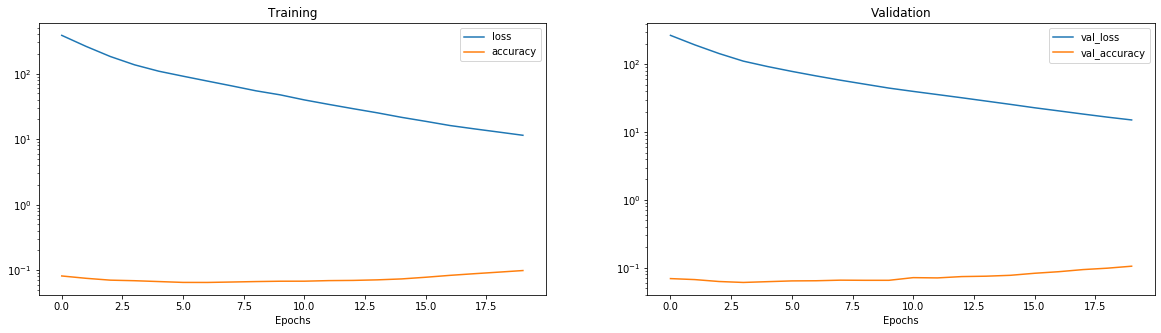

In [16]:
plot_network_learning_graphs(cnn_net)

## Error Rate

In [17]:
error_rate(y_test.argmax(1), y_pred.argmax(1))

0.8950617283950617

## Classification Report

In [18]:
print(classification_report(y_test.argmax(1), y_pred.argmax(1)))

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       439
           1       0.00      0.00      0.00       439
           2       0.21      0.13      0.16       440
           3       0.21      0.30      0.25       440
           4       0.15      0.09      0.11       440
           5       0.07      0.04      0.05       440
           6       0.07      0.16      0.10       440

    accuracy                           0.10      3078
   macro avg       0.10      0.10      0.10      3078
weighted avg       0.10      0.10      0.10      3078



## Confusion Matrix

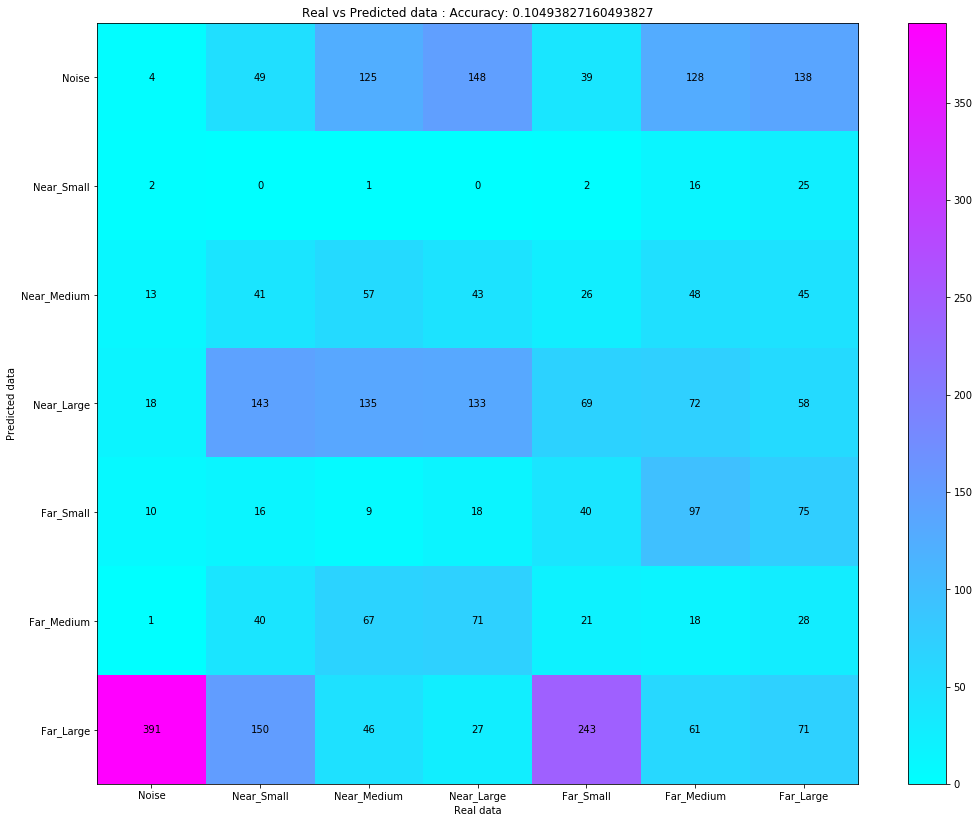

In [19]:
plot_confustion_matrix(y_test, y_pred, df, prob=True)